In [1]:
from PIL import Image, ImageChops, ImageDraw
import random, numpy as np
import fitz

def load_pdf(im):
    doc = fitz.open(im)
    page = doc[0]
    zoom = 1
    mat = fitz.Matrix(zoom, zoom)
    pix = page.get_pixmap(matrix=mat)
    return Image.frombytes('RGB', [pix.width, pix.height], pix.samples)

def draw_ocr_bboxes(image, prediction, scale=1):
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['bboxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = (1, 0, 255)
        new_box = (np.array(box) * scale).tolist()
        draw.rectangle(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",
        
                    fill=color)
       
    display(image)
    return image

In [2]:
import requests
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM 

#Extract tables and figures only
#model_name = 'yifeihu/TF-ID-large'
#model_name = 'yifeihu/TF-ID-large-no-caption'

#Extract all text, tables and figures
model_name = 'yifeihu/TFT-ID-1.0'
model_name = 'yifeihu/Florence-2-DocLayNet-Fixed'

model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)

c:\users\yushl\desktop\ws\yifeihu\env\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedMod

In [27]:
%%time
prompt = "<OD>"

#url = "https://huggingface.co/yifeihu/TF-ID-base/resolve/main/arxiv_2305_10853_5.png?download=true"
#image = Image.open(requests.get(url, stream=True).raw)

image = Image.open('invoice7.png').convert('RGB')
#image = load_pdf('2023-form-5500.pdf')
#image = load_pdf('t5008-23b.pdf')
image = Image.open('loan1.png').convert('RGB')

inputs = processor(text=prompt, images=image, return_tensors="pt")

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=20
)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))
print(parsed_answer)

{'<OD>': {'bboxes': [[107.35050201416016, 105.14900207519531, 471.2505187988281, 148.5989990234375], [107.35050201416016, 172.93099975585938, 550.0955200195312, 195.52500915527344], [107.35050201416016, 223.3330078125, 187.40850830078125, 245.927001953125], [107.35050201416016, 247.66500854492188, 930.9775390625, 270.2590026855469], [107.35050201416016, 296.3290100097656, 935.8295288085938, 320.6610107421875], [107.35050201416016, 372.8009948730469, 1109.28857421875, 421.4649963378906], [107.35050201416016, 447.5350036621094, 336.6075134277344, 471.86700439453125], [107.35050201416016, 471.86700439453125, 753.8795166015625, 496.1990051269531], [107.35050201416016, 522.2689819335938, 1091.093505859375, 562.2429809570312], [107.35050201416016, 572.6710205078125, 1108.0755615234375, 645.6669921875], [107.35050201416016, 673.4750366210938, 1086.2415771484375, 746.4710083007812], [107.35050201416016, 774.2789916992188, 1111.714599609375, 821.2050170898438], [106.13750457763672, 774.27899169

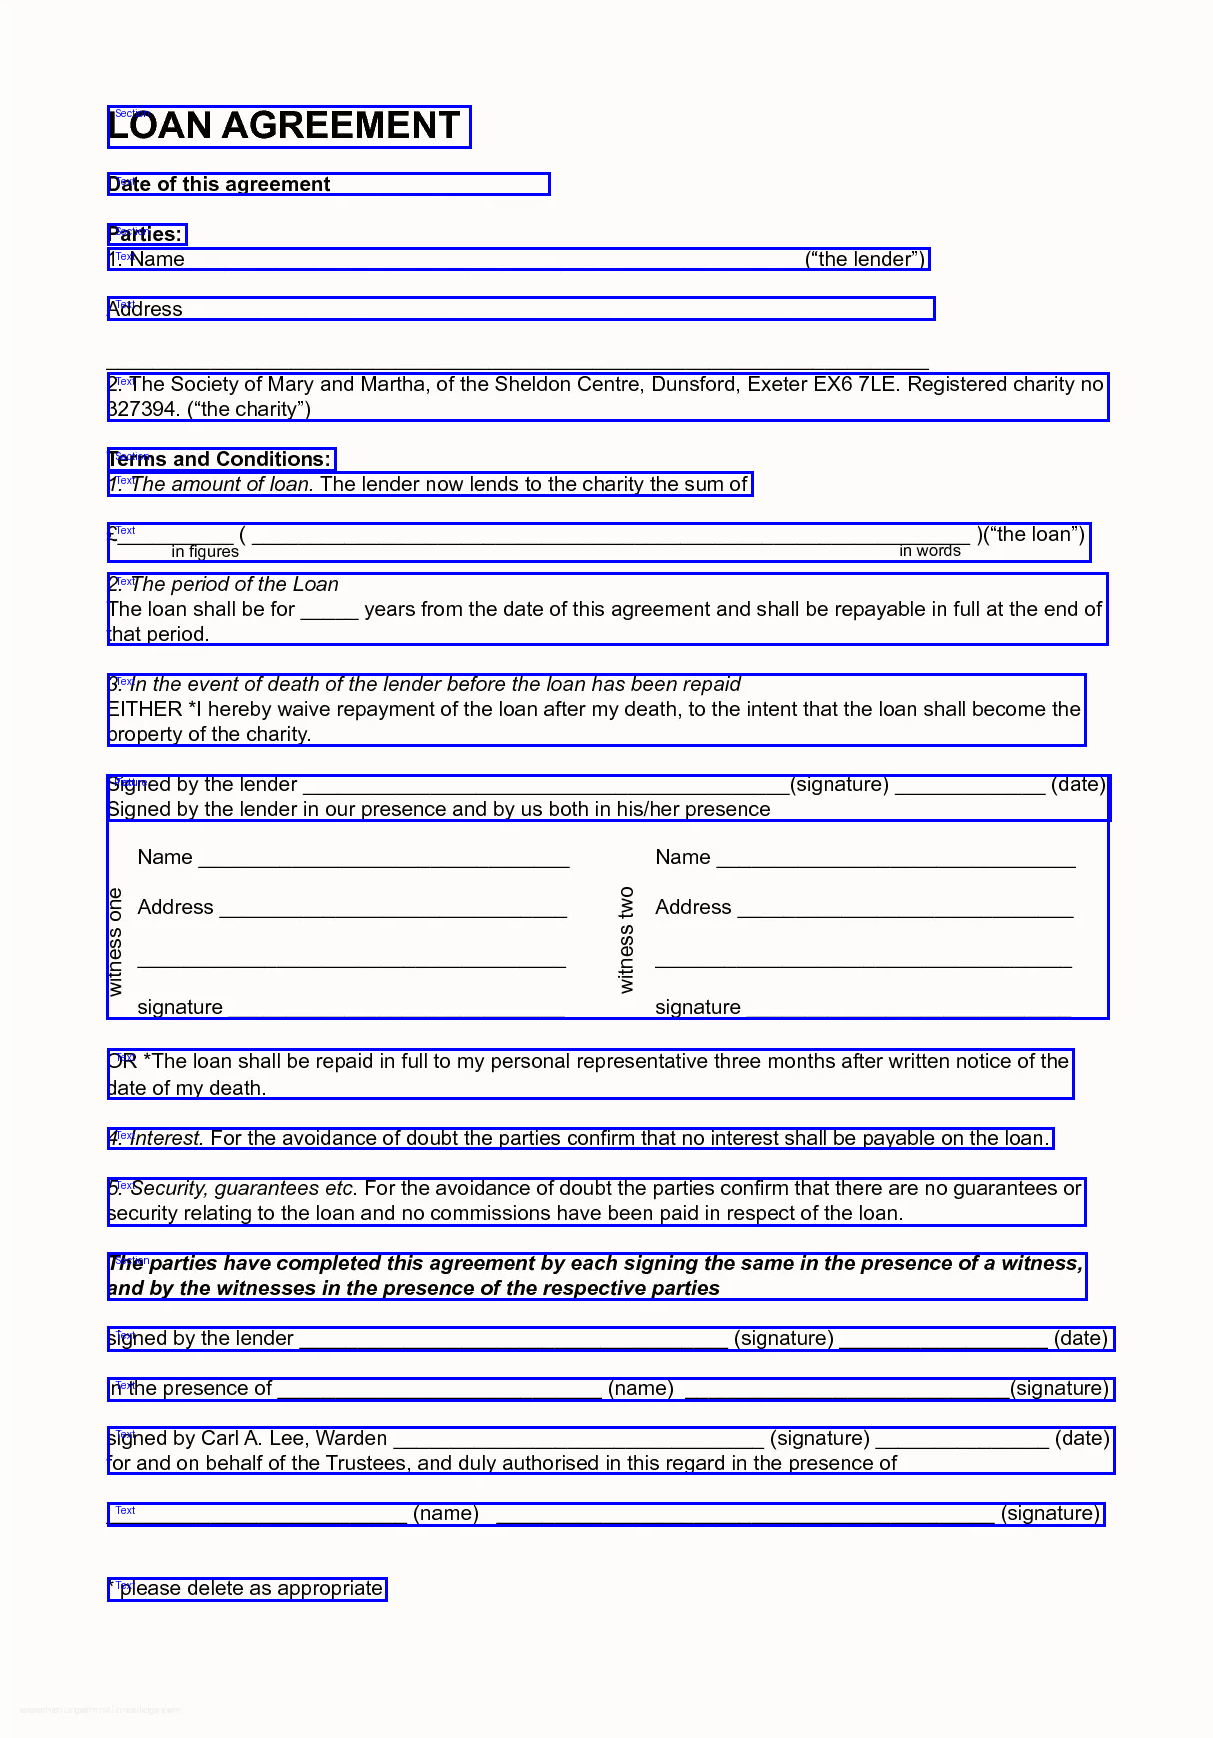

In [28]:
output_image = image
w, h = output_image.size
scale = 800 / max(w, h)
scale = 1
new_output_image = output_image.resize((int(w * scale), int(h * scale)))
p = draw_ocr_bboxes(output_image, parsed_answer['<OD>'], scale=1) 